# Causal Inference with DoWhy Python 

Activate "dowhy" conda environment (Python 3.12)

### Source 1: The Causal Story Behind Hotel Booking Cancellations

https://github.com/py-why/dowhy/blob/main/docs/source/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.ipynb



In [11]:
# 1. load the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import dowhy

In [18]:
# 2. Get the data

dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')

print(dataset.columns)

dataset.head()

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [19]:
# 3. Feature Engineering: create new features and reduce the dataset dimensions

## Total Stay (nights) = stays_in_weekend_nights + stays_in_week_nights
dataset['total_stay'] = dataset['stays_in_week_nights'] + dataset['stays_in_weekend_nights']


## Total # of Guests = adults + children + babies
dataset['guests'] = dataset['adults'] + dataset['children'] + dataset['babies']


## Different_room_assigned = 1 if reserved_room_type & assigned_room_type are different, 0 otherwise.
dataset['different_room_assigned'] = 0
slice_indices = dataset['reserved_room_type'] != dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned'] = 1

## Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)

## remove other columns that either contain NULL values or have too many unique values
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries 
dataset = dataset.drop(['agent','company'],axis=1)

## Replacing/impute missing countries with most freqently occuring countries
dataset['country'] = dataset['country'].fillna(dataset['country'].mode()[0])


dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
## remove distribution_channel since it has a high overlap with market_segment
dataset = dataset.drop(['distribution_channel'], axis=1)

## Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)

dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

dataset_copy = dataset.copy(deep=True)

print(dataset.columns)
dataset.iloc[:, 5:20].head(100)


Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,73.80,0,1,2,2.0
96,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,117.00,0,1,7,2.0
97,HB,ESP,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,196.54,0,1,7,3.0
98,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,99.30,1,2,7,3.0


In [22]:
# 4. Calculating expected counts
'''
Since the number of number of cancellations and the number of times a different room 
was assigned is heavily imbalanced, we first choose 1000 observations at random to 
see that in how many cases do the variables; 'is_cancelled' & 'different_room_assigned' 
attain the same values. This whole process is then repeated 10000 times and the 
expected count turns out to be near 50% (i.e. the probability of these two variables 
attaining the same value at random). So statistically speaking, we have no definite 
conclusion at this stage. Thus assigning rooms different to what a customer had 
reserved during his booking earlier, may or may not lead to him/her cancelling that booking.
'''
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset.sample(1000) 
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i

print("Expected Count of cancellations when the assigned rooms are different than booked room :", counts_sum/(10000))


# Expected Count when there are no booking changes 
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]==0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i

print("Expected Count of cancellations when there are no booking changes:", counts_sum/(10000))


# Expected Count when there are booking changes = 66.4%
counts_sum=0
for i in range(1,10000):
        counts_i = 0
        rdf = dataset[dataset["booking_changes"]>0].sample(1000)
        counts_i = rdf[rdf["is_canceled"]== rdf["different_room_assigned"]].shape[0]
        counts_sum+= counts_i

print("Expected Count of cancellations when there are booking changes:", counts_sum/(10000))



Expected Count of cancellations when the assigned rooms are different than booked room : 588.764
Expected Count of cancellations when there are no booking changes: 572.5529
Expected Count of cancellations when there are booking changes = 66.4%: 665.9601


When the number of booking changes are non-zero we see higher counts of cancellations (66.5% vs ~58%). This indicates that Booking Changes may affect the cancellations (aka confounding variable). 


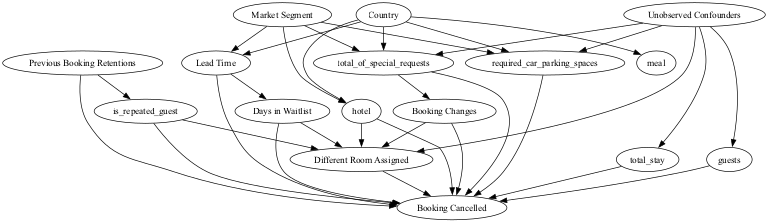

In [25]:
# 5. DoWhy 1 - Create a Causal Graph
'''
Assumptions on what variables affect other variables:
    Market Segment -> [ Lead Time ]
    Country -> [ Lead Time, Meal ]
    Lead Time -> [ Days in Waitlist, Cancellations ]
    [ Days in Waitlist, Total Stay, Guests ] -> [ Cancellations ]
    [ previous_bookings_not_canceled, previous_cancellations]   -> [ is_repeated_guest, Cancellations ]
    Booking Changes -> [ Different Room, Cancellation ] --> Confounder
    Different Room  -> [ Cancellation ]
    Unobserved Confounders that might be affecting both the Treatment and Outcome ...
 '''

import pygraphviz
causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders",observed="no"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->{different_room_assigned,required_car_parking_spaces,guests,total_stay,total_of_special_requests};
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->{is_canceled,different_room_assigned};
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> {different_room_assigned,is_canceled};
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled; 
hotel -> {different_room_assigned,is_canceled};
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> {booking_changes,is_canceled};
country->{hotel, required_car_parking_spaces,total_of_special_requests};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests};
}"""



# To identofy causal effect, remove the unobserved confounder node from the graph
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))


Treatment is assigning the same type of room reserved by the customer during Booking. 

Outcome would be whether the booking was cancelled or not. 

Common Causes represent the variables that according to us have a causal affect on both Outcome and Treatment. As per our causal assumptions, the 2 variables satisfying this criteria are Booking Changes and the Unobserved Confounders. 

In [26]:
# 6. DoWhy 2 - Identify the Causal Effect
## Treatment causes Outcome if changing Treatment leads to a change in Outcome keeping everything else constant. 

## Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|required_car_parking_spaces,is_repeat
d[different_room_assigned]                                                    

                                                                              
ed_guest,days_in_waiting_list,lead_time,hotel,guests,total_of_special_requests
                                                                              

                             
,total_stay,booking_changes])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,required_car_parking_spaces,is_repeated_guest,days_in_waiting_list,lead_time,hotel,guests,total_of_special_requests,total_stay,booking_changes,U) = P(is_canceled|different_room_assigned,required_car_parkin

In [27]:
# 7. DoWhy 3 - Estimate the identified estimand


estimate = model.estimate_effect(identified_estimand, 
                                 method_name="backdoor.propensity_score_weighting",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(E[is_canceled|required_car_parking_spaces,is_repeat
d[different_room_assigned]                                                    

                                                                              
ed_guest,days_in_waiting_list,lead_time,hotel,guests,total_of_special_requests
                                                                              

                             
,total_stay,booking_changes])
                             
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_assigned,required_car_parking_spaces,is_repeated_guest,days_in_waiting_list,lead_time,hotel,guests,total_of_special_requests,total_stay,boo

Based on the output, having a different room assigned decreases the chances of a cancellation. 

Q1: is this the correct causal effect? 

Q2: Could it be that different rooms are assigned only when the booked room is unavailable, and therefore assigning a different room has a positive effect on the customer (as opposed to not assigning a room)?

Q3: Perhaps assigning a different room only happens at check-in, and the chances of a cancellation once the customer is already at the hotel are low? 
    -> Does different_room_assigned happen mostly on the day of the booking?


! While the associational analysis earlier indicated a positive correlation between is_canceled and different_room_assigned, estimating the causal effect using DoWhy presents a different picture. It implies that a decision/policy to reduce the number of different_room_assigned at hotels may be counter-productive.


In [28]:
# 8. DoWhy 4 - Refute Results 
## Causal part comes from the assumptions (not the data) and lead to identification
## Data is used for statistical estimation.
## -> Verifying the assumptions correctness is critical.

''' Method 1: Random Common Cause- 
    Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. 
    If our assumption was originally correct then the causal estimate shouldn't change by much.
'''

refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

'''
Method-2: Placebo Treatment Refuter -
    Randomly assigns any covariate as a treatment and re-runs the analysis. 
    If our assumptions were correct then this newly found out estimate should go to 0.
'''

refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)


'''
Method-3: Data Subset Refuter -
    Creates subsets of the data(similar to cross-validation) and 
        checks whether the causal estimates vary across subsets. 
    If our assumptions were correct there shouldn't be much variation.
'''

refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Add a random common cause
Estimated effect:-0.26222126829714804
New effect:-0.26222676664729216
p value:0.9

Refute: Use a Placebo Treatment
Estimated effect:-0.26222126829714804
New effect:-0.00042626115041261405
p value:0.8400000000000001

Refute: Use a subset of data
Estimated effect:-0.26222126829714804
New effect:-0.26215456090543077
p value:0.92



We can see that our estimate passes all three refutation tests. This does not prove its correctness, but it increases confidence in the estimate.

### Source 2: Kaggle - a practical guide

https://www.kaggle.com/code/adamwurdits/causal-inference-with-dowhy-a-practical-guide

Judea Pearl's Structural Causal Model (SCM):

1. Define: Express the target quantity Q as a function Q(M) that can be computed from any model M.

2. Assume: Formulate causal assumptions using ordinary scientific language and represent their structural part in graphical form.

3. Identify: Determine if the target quantity is identifiable (i.e., expressible in terms of estimable parameters).

4. Estimate: Estimate the target quantity if it is identifiable, or approximate it, if it is not. Test the statistical implications of the model, if any, and modify the model when failure occurs.


In [3]:
# 1. Load the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install dowhy
import dowhy
from dowhy import CausalModel

import warnings
warnings.filterwarnings('ignore')

In [4]:
# 2. Generate/load data
np.random.seed(42)

num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,0,1,521,False
1,0,0,2,488,False
2,0,0,3,479,False
3,0,0,4,475,False
4,0,0,5,456,False
...,...,...,...,...,...
119995,9999,2,8,541,True
119996,9999,2,9,499,True
119997,9999,2,10,518,True
119998,9999,2,11,488,True


In [5]:
# 3. Create a digraph for modeling a causal problem
i = 3

causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

In [6]:
# 4. Post-process the data based on the graph and the month of the treatment (signup) 
# For each customer, determine their average monthly spend before and after month i
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)

      user_id  signup_month  treatment  pre_spends  post_spends
0           0             0      False       504.5   422.777778
1           2             0      False       485.0   434.000000
2           4             0      False       488.5   420.111111
3           5             0      False       475.0   408.333333
4           6             0      False       494.0   423.666667
...       ...           ...        ...         ...          ...
5468     9992             0      False       456.5   404.888889
5469     9993             0      False       503.0   431.888889
5470     9994             0      False       480.0   411.444444
5471     9996             0      False       453.0   406.888889
5472     9997             0      False       461.0   415.111111

[5473 rows x 5 columns]


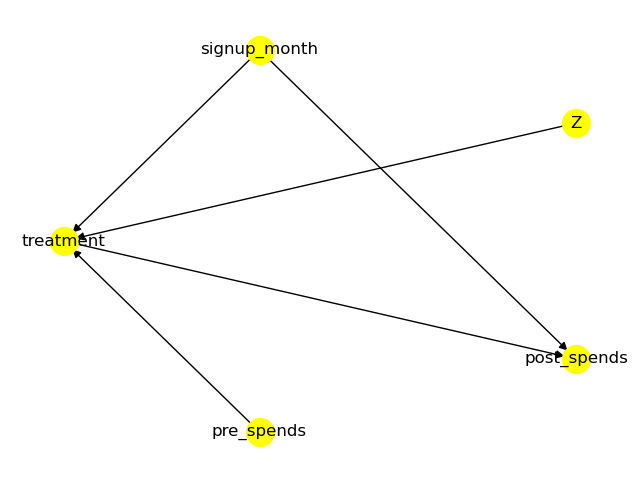

In [7]:
# 5. Model the causal problem
model = dowhy.CausalModel(data=df_i_signupmonth,
                          graph=causal_graph.replace("\n", " "),
                          treatment="treatment",
                          outcome="post_spends")
model.view_model()

In [8]:
# 6. Identify a target estimand under the model
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[Z  pre_spends]              ⎝d[Z  pre_spends]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z,pre_spends})
Estimand assumption 2, Exclusion: If we remove {Z,pre_spends}→{treatment}, then ¬({Z,pre_spends}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
# 7. Estimate causal effect based on the identified estimand
estimate = model.estimate_effect(identified_estimand,
                                 method_name='backdoor.propensity_score_matching',
                                 target_units='att')
print(estimate)

propensity_score_matching
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 97.49138947865055



In [10]:
# 8. Refute the obtained estimate
refutation = model.refute_estimate(identified_estimand, estimate, method_name='placebo_treatment_refuter',
                     placebo_type='permute', num_simulations=20)
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:97.49138947865055
New effect:-3.6721868365180397
p value:0.16768642690453084

